<a href="https://colab.research.google.com/github/TsvetaIvanova/ColabIMLO/blob/main/OffIMLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running instructions

## imports

In [ ]:
import pandas as pd
from sklearn import datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, transforms
import time
from PIL import Image
from scipy.io import loadmat
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from google.colab import runtime
from google.colab import drive


#Get full dataset into dataframe


In [ ]:
print(torch.__version__)
# !pip install torch==2.2.2

2.2.1+cu121


# Get and process data


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:

data_train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(50),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transforms.Normalize(mean=([0.5014, 0.4112, 0.3327]), std=([0.2578, 0.2079, 0.2205]))
])

data_val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(50),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transforms.Normalize(mean=([0.5014, 0.4112, 0.3327]), std=([0.2578, 0.2079, 0.2205]))
])

data_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transforms.Normalize(mean=([0.5014, 0.4112, 0.3327]), std=([0.2578, 0.2079, 0.2205]))
])





In [ ]:
def show_image(dataset, index=0):
    image, label = dataset[index]
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.show()




In [ ]:
train_set = datasets.Flowers102(root='data', split='train', download=True, transform=data_train_transform)
test_set = datasets.Flowers102(root='data', split='test', download=True, transform=data_test_transform)
val_set = datasets.Flowers102(root='data', split='val', download=True, transform=data_val_transform)


# creating data loaders

train_loader = DataLoader(dataset=train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
val_loader = DataLoader(dataset=val_set, batch_size=16, shuffle=False)


100%|██████████| 344862509/344862509 [00:15<00:00, 21754526.75it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 510929.53it/s]


100%|██████████| 14989/14989 [00:00<00:00, 13419087.01it/s]


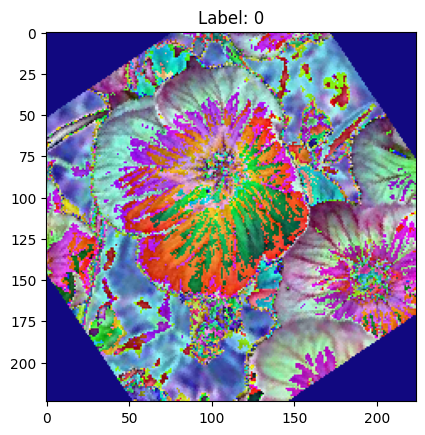

In [ ]:
show_image(train_set)

## using the datasets.Flowers102 function

# preprocess data for training


# Test

# NN Architecture(Neural Network)


## define the model

In [ ]:
#a second dropout to the best performing one, 53.8train, 51%test 150epochs

class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(512 * 14 * 14, 1024)
        self.bn5 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 102)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 512 * 14 * 14)
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout1(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [ ]:
  # Training function
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if batch % 10 == 0:
            print(f'Epoch {t+1}, Batch {batch}, Loss: {loss.item():.4f}')
        if batch == 0:
            start_time = time.time()
        elif batch == 1:
            elapsed_time = time.time() - start_time
            print(f"Time per batch: {elapsed_time:.2f} seconds")

    average_loss = total_loss / len(dataloader)
    print(f'Average Loss: {average_loss:.4f}')


In [ ]:
# Testing function
def test(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss  # Ensure this value is returned


In [ ]:
model = ConvNN().to(device)
print(model)

# LossFN
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)  # Added L2 regularization
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)




NameError: name 'ConvNN' is not defined

# Train and Evaluation


In [ ]:
# Training and evaluation loop
epochs = 400
for t in range(epochs):
    print(f"Epoch {t+1}/{epochs},\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    if t >= 19:
      val_loss = test(val_loader, model, loss_fn)
      scheduler.step(val_loss)

    # Checkpointing every 100 epochs
    if t % 100 == 0 and t != 0:
        torch.save(model.state_dict(), f'model_epoch_{t}.pth')
        print(f'Checkpoint saved at epoch {t}')

print("This marks the end of training the model, now commences the eval stage on the test data")


Epoch 1/400,
-------------------------------
Epoch 1, Batch 0, Loss: 4.6852
Time per batch: 0.24 seconds
Epoch 1, Batch 10, Loss: 4.4375
Epoch 1, Batch 20, Loss: 4.3480
Epoch 1, Batch 30, Loss: 4.7617
Epoch 1, Batch 40, Loss: 4.5335
Epoch 1, Batch 50, Loss: 4.3839
Epoch 1, Batch 60, Loss: 4.0423
Average Loss: 4.5472
Epoch 2/400,
-------------------------------
Epoch 2, Batch 0, Loss: 4.3538
Time per batch: 0.21 seconds
Epoch 2, Batch 10, Loss: 3.4818
Epoch 2, Batch 20, Loss: 4.1586
Epoch 2, Batch 30, Loss: 3.9542
Epoch 2, Batch 40, Loss: 3.4536
Epoch 2, Batch 50, Loss: 4.0485
Epoch 2, Batch 60, Loss: 3.5718
Average Loss: 3.8727
Epoch 3/400,
-------------------------------
Epoch 3, Batch 0, Loss: 3.8967
Time per batch: 0.20 seconds
Epoch 3, Batch 10, Loss: 3.4966
Epoch 3, Batch 20, Loss: 3.3945
Epoch 3, Batch 30, Loss: 3.8426
Epoch 3, Batch 40, Loss: 3.6158
Epoch 3, Batch 50, Loss: 3.6053
Epoch 3, Batch 60, Loss: 3.6762
Average Loss: 3.5345
Epoch 4/400,
-------------------------------
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Streaming output truncated to the last 5000 lines.
Epoch 44, Batch 0, Loss: 0.3915
Time per batch: 0.20 seconds
Epoch 44, Batch 10, Loss: 0.6171
Epoch 44, Batch 20, Loss: 0.6519
Epoch 44, Batch 30, Loss: 0.5803
Epoch 44, Batch 40, Loss: 0.8404
Epoch 44, Batch 50, Loss: 0.3138
Epoch 44, Batch 60, Loss: 0.5207
Average Loss: 0.5309
Test Error: 
 Accuracy: 49.7%, Avg loss: 2.003638 

Epoch 45/400,
-------------------------------
Epoch 45, Batch 0, Loss: 0.2219
Time per batch: 0.21 seconds
Epoch 45, Batch 10, Loss: 0.3382
Epoch 45, Batch 20, Loss: 0.5615
Epoch 45, Batch 30, Loss: 0.5943
Epoch 45, Batch 40, Loss: 0.6107
Epoch 45, Batch 50, Loss: 0.5575
Epoch 45, Batch 60, Loss: 0.2926
Average Loss: 0.5444
Test Error: 
 Accuracy: 52.3%, Avg loss: 1.971791 

Epoch 46/400,
-------------------------------
Epoch 46, Batch 0, Loss: 0.3406
Time per batch: 0.21 seconds
Epoch 46, Batch 10, Loss: 0.7721
Epoch 46, Batch 20, Loss: 0.7089
Epoch 46, Batch 30, Loss: 0.8026
Epoch 46, Batch 40, Loss: 0.4122


## split and format the dataset

## Create a checkpoint for the training and testing in case I have to pause

## Create a visualisation

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

NameError: name 'model' is not defined

In [ ]:
model = ConvNN().to(device)
model.load_state_dict(torch.load("model.pth"))

NameError: name 'ConvNN' is not defined

## Set training parameters

## train

# Eval

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the model to evaluation mode
model.eval()

# Evaluation loop
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move images and labels to GPU if available
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total} %')


NameError: name 'model' is not defined

In [ ]:
runtime.unassign()